In [4]:
from skimage.io import imread, imshow, imsave
from skimage.transform import resize, rotate
import matplotlib.pyplot as plt
import numpy as np
import os
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import random
from sklearn.model_selection import train_test_split
import glob
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import shutil

Using TensorFlow backend.


In [6]:
len(np.linspace(0,0.5))

50

In [2]:
path_train = '/home/neuralbee/workspace/anti_spoof_detection/data/IDRND_FASDB_train/'
path_val = '/home/neuralbee/workspace/anti_spoof_detection/data/IDRND_FASDB_val/'
path_test = '/home/neuralbee/workspace/anti_spoof_detection/data/test/'
BATCH_SIZE = 2
img_rows = 224
img_cols = 224
nb_classes = 2

In [3]:
train_real_filelist = glob.glob(os.path.join(path_train, 'real/*.png'))
train_spoof_filelist = glob.glob(os.path.join(path_train, 'spoof/*.png'))
train_filelist = train_real_filelist + train_spoof_filelist
train_labels = [0] * len(train_real_filelist) + [1] * len(train_spoof_filelist)
train = pd.DataFrame()
train['path'] = train_filelist
train['label'] = train_labels

val_real_filelist = glob.glob(os.path.join(path_val, 'real/*.png'))
val_spoof_filelist = glob.glob(os.path.join(path_val, 'spoof/*.png'))
val_filelist = val_real_filelist + val_spoof_filelist
val_labels = [0] * len(val_real_filelist) + [1] * len(val_spoof_filelist)
val = pd.DataFrame()
val['path'] = val_filelist
val['label'] = val_labels

NameError: name 'glob' is not defined

In [2]:
train['label'].astype('str')

NameError: name 'train' is not defined

In [4]:
from keras.preprocessing.image import 

train_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode = 'reflect')

test_datagen = ImageDataGenerator(rescale=1./255, fill_mode = 'nearest')

train_gen = train_gen.flow_from_directory(
        path_train,
        target_size=(img_rows, img_rows),
        batch_size=BATCH_SIZE,
        class_mode='binary')

val_gen = test_datagen.flow_from_directory(
        path_val,
        target_size=(img_rows, img_rows),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 8299 images belonging to 2 classes.
Found 1005 images belonging to 2 classes.


# Build Model

In [5]:
from keras.applications import DenseNet201
model = DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_rows, img_cols, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(2048, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
x = Dense(1024, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [6]:
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Model

from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
  
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0001, decay=0.0001), metrics=['accuracy',auc,f1])

In [7]:
train_gen.class_indices

{'real': 0, 'spoof': 1}

In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

weight_path='DensNet201_part2.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_auc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=False)

reduceLROnPlat = ReduceLROnPlateau(monitor='f1', factor=0.1, patience=3, 
                                   verbose=1, mode='max', min_lr=0.0000001)

def exp_decay(epoch):
    initial_lrate = 0.0001
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
  
callbacks_list = [checkpoint, lrate]

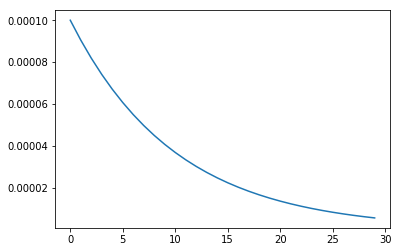

In [9]:
lr = [exp_decay(i) for i in range(30)]
plt.plot(lr)

In [10]:
loss_history = [model_final.fit_generator(train_gen, 
                             steps_per_epoch = 8300/BATCH_SIZE, 
                             epochs = 50,
                             validation_data = val_gen,
                             validation_steps = 1000/BATCH_SIZE,
                             callbacks = callbacks_list)]

Epoch 1/50
4150/4150 [==============================] - 1001s 241ms/step - loss: 0.9049 - acc: 0.8107 - auc: 0.5444 - f1: 0.8612 - val_loss: 1.4367 - val_acc: 0.6280 - val_auc: 0.5157 - val_f1: 0.7087

Epoch 00001: val_auc improved from -inf to 0.51567, saving model to DensNet201_part2.h5
Epoch 2/50
4150/4150 [==============================] - 943s 227ms/step - loss: 0.8534 - acc: 0.8448 - auc: 0.5074 - f1: 0.8888 - val_loss: 1.1822 - val_acc: 0.6296 - val_auc: 0.5181 - val_f1: 0.7070

Epoch 00002: val_auc improved from 0.51567 to 0.51806, saving model to DensNet201_part2.h5
Epoch 3/50
4150/4150 [==============================] - 943s 227ms/step - loss: 0.8324 - acc: 0.8498 - auc: 0.5178 - f1: 0.8933 - val_loss: 1.3250 - val_acc: 0.6176 - val_auc: 0.5171 - val_f1: 0.6957

Epoch 00003: val_auc did not improve from 0.51806
Epoch 4/50
4150/4150 [==============================] - 945s 228ms/step - loss: 0.7857 - acc: 0.8498 - auc: 0.5218 - f1: 0.8929 - val_loss: 1.1953 - val_acc: 0.6276 - 

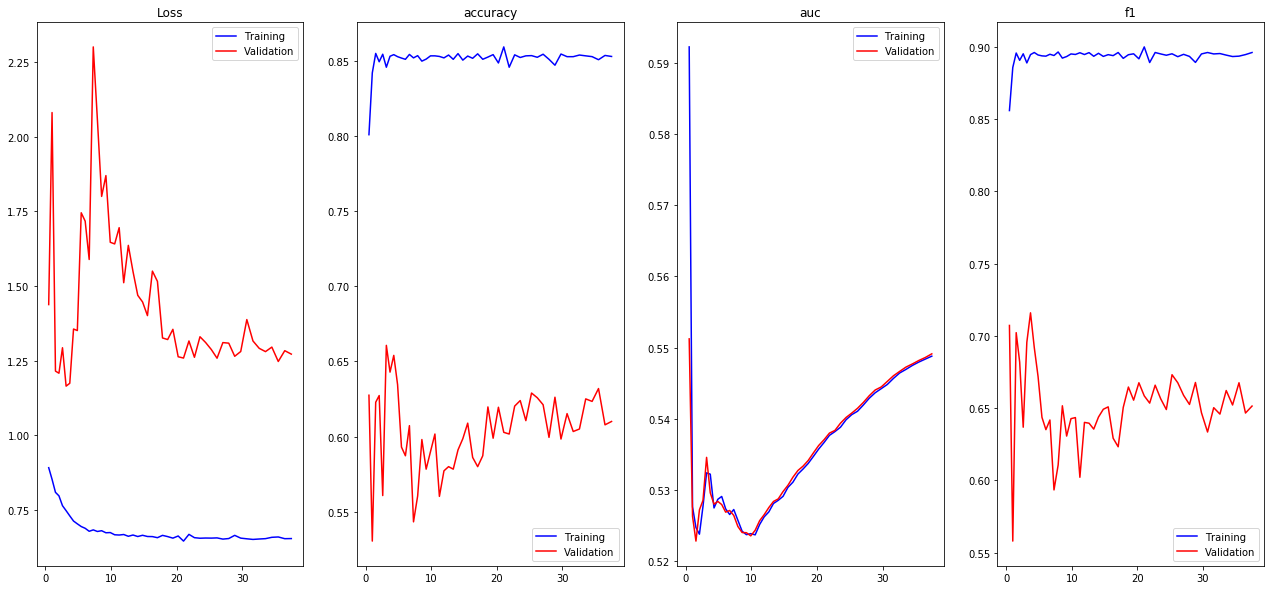

In [11]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['acc'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_acc'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('accuracy')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['auc'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_auc'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('auc')

    _ = ax4.plot(epich, np.concatenate(
        [mh.history['f1'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_f1'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('f1')
    
show_loss(loss_history)

In [11]:
a = {'1':1, '2':2}

In [12]:
a

{'1': 1, '2': 2}

In [5]:
K.clear_session()

NameError: name 'K' is not defined

# TEST

In [ ]:
from keras.models import load_model
model_final = load_model('DensNet201_part1.h5', custom_objects={'auc':auc, 'f1':f1})

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
pred1 = []
pred2 = []
pred3 = []
pred4 = []
for img in tqdm(test_filelist):
    image1 = imread(img)
    image2 = np.fliplr(image1)
    image3 = np.flipud(image1)
    image4 = np.flipud(image2)

    image1 = resize(image1, (img_rows, img_cols, 3))
    image2 = resize(image2, (img_rows, img_cols, 3))
    image3 = resize(image3, (img_rows, img_cols, 3))
    image4 = resize(image4, (img_rows, img_cols, 3))

    pred1.append(model_final.predict(image1.reshape((1,image1.shape[0],image1.shape[1],image1.shape[2])))[0][0])
    pred2.append(model_final.predict(image2.reshape((1,image2.shape[0],image2.shape[1],image2.shape[2])))[0][0])
    pred3.append(model_final.predict(image3.reshape((1,image3.shape[0],image3.shape[1],image3.shape[2])))[0][0])
    pred4.append(model_final.predict(image4.reshape((1,image4.shape[0],image4.shape[1],image4.shape[2])))[0][0])

In [ ]:
test.drop(columns=[0,2], inplace=True)

In [ ]:
test['path'] = [*map(lambda x: x.split('/')[2], test_filelist)]
test['pred'] = pred1
test.columns = [0,2]

test.to_csv('predict1.csv', index=False)

test[2] = pred2
test.to_csv('predict2.csv', index=False)

test[2] = pred3
test.to_csv('predict3.csv', index=False)

test[2] = pred4
test.to_csv('predict4.csv', index=False)

In [ ]:
from __future__ import division
from collections import defaultdict
from glob import glob
import sys


def kaggle_bag(glob_files, loc_outfile):
    with open(loc_outfile,"w") as outfile:
    all_ranks = defaultdict(list)
    for i, glob_file in enumerate( glob(glob_files) ):
        file_ranks = []
        print("parsing: {}".format(glob_file))
        # sort glob_file by first column, ignoring the first line
        lines = open(glob_file).readlines()
        lines = [lines[0]] + sorted(lines[1:])
        for e, line in enumerate( lines ):
            if e == 0 and i == 0:
                outfile.write( line )
            elif e > 0:
                r = line.strip().split(",")
                file_ranks.append( (float(r[1]), e, r[0]) )
        for rank, item in enumerate( sorted(file_ranks) ):
            all_ranks[(item[1],item[2])].append(rank)
    average_ranks = []
    for k in sorted(all_ranks):
        average_ranks.append((sum(all_ranks[k])/len(all_ranks[k]),k))
    ranked_ranks = []
    for rank, k in enumerate(sorted(average_ranks)):
        ranked_ranks.append((k[1][0],k[1][1],rank/(len(average_ranks)-1)))
    for k in sorted(ranked_ranks):
        outfile.write("%s,%s\n"%(k[1],k[2]))
    print("wrote to {}".format(loc_outfile))


In [ ]:
kaggle_bag("predict*.csv", 'submission1tta.csv')

In [ ]:
function dump(o)
	if type(o) == 'table' then
		local s = '{ '
		for k,v in pairs(o) do
			if type(k) ~= 'number' then k = '"'..k..'"' end
			s = s .. '['..k..'] = ' .. dump(v) .. ','
		end
		return s .. '} '
	else
		return tostring(o)
	end
end